In [1]:
import os
import sys
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from collections import deque
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from itertools import count
import random
import scipy.stats as stats
from tqdm import tqdm
import math 

from DAAN572_Project.policies import ContinuousPolicy
# from DAAN572_Project.policies import MyController as ContinuousPolicy
from DAAN572_Project.utils import compute_loss
from DAAN572_Project.utils import CVGA_score


In [2]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# configure module & syspath
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# set device    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from gym.envs.registration import register
register(
    id='simglucose-adolescent1-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002'}
)
env = gym.make('simglucose-adolescent1-v0')

/home/daniel/miniconda3/lib/python3.10/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
rewards_queue = deque()
rewards_ma = list()
run_duration = []
total_loss = []
state_lookback = 20
def get_num_params(lb):
    parms = (lb*3)+3
    return parms
num_state_features = get_num_params(state_lookback)
pi = ContinuousPolicy(1) 


In [5]:
max_episodes = 100
max_trajectory_length = 480
discount_factor = 0.95
epsilon = 0.95
running_bg = []
optimizer = optim.Adam(pi.parameters(), lr = 0.0001)


In [6]:
for epi in tqdm(range(max_episodes)):
       
#     failure_penalty = -999999        

    emergency_status = 0
    emergency_penalty = -1000
    
    ####################################
    ### INSTANTIATE OBSERVATION VARS ###
    ####################################
    observation = env.reset()
    observation = observation[0]
    observation = (observation - 39)/600
    observation_lag = observation
    observation_change = observation - observation_lag        
    observation_hist = np.zeros(state_lookback)
    for i in range(state_lookback):
        observation_hist[i] = observation_change
    observation_hist_norm = observation_hist
    
    
    #######################################
    ### INSTANTIATE ACTION HISTORY VARS ###
    #######################################
    insulin = 0.02
    insulin_norm = insulin / 30
    insulin_lag = insulin_norm
    insulin_hist = np.zeros(state_lookback)
    for i in range(state_lookback):
        insulin_hist[i] = insulin_norm
    insulin_hist_norm = insulin_hist

    
    ##############################################
    ### INSTANTIATE PLANNED MEAL HISTORY ARRAY ###
    ##############################################
    planned_meal = env.env.patient.planned_meal
    planned_meal_hist = np.zeros(state_lookback)
    planned_meal_hist_norm = planned_meal_hist
    planned_meal = 0
    planned_meal_lag = 0
    

    ################################################
    ### INSTANTIATE CUSTOM REWARD FUNCTION ARRAY ###
    ################################################
    CVGA_scores = []
    unobserved_CVGA_scores = np.zeros(8)    
    for i in range(8):
        unobserved_CVGA_scores[i] = -65    
        
    #################################
    ### INSTANTIATE CUR STATE VAR ###
    #################################
    
#     state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()
    state = torch.tensor(observation).unsqueeze(dim=0)
    print(state)
    reward = 0
    done = False



    ###############################
    ### LOOP THROUGH TRAJECTORY ###
    ###############################
    
    for t in range(max_trajectory_length):
        
        ########################
        ### DETERMINE ACTION ###
        ########################
        
        if random.uniform(0, 1) < epsilon:
#             insulin = pi.act(torch.from_numpy(state.astype(np.float32)))[0]
#             insulin = pi.act(env.env.patient.state)[0]
    
            insulin = pi.policy(state)
    
        else:
#             rec_insulin = pi.act(torch.from_numpy(state.astype(np.float32)))[0]
            rec_insulin = pi.policy(observation, reward, done)
            a, b = 0, 30
            mu, sigma = rec_insulin, 2
            dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
            insulin = dist.rvs(1)[0]          
                
        
        
        ######################
        ### PERFORM ACTION ###
        ######################
        observation, reward, done, _ = env.step(insulin)  
        
        
        ##########################################
        ### POPULATE OBSERVATION HISTORY ARRAY ###
        ##########################################
        observation = (observation[0] - 39)/600           # normalize glucose level to a value between 0 and 1
        observation_chg = observation - observation_lag   # create change value since previous time period
        observation_hist = np.roll(observation_hist,1)    # cycle the array by 1 position and move the oldest value from the rightmost position to first position
        observation_hist[0] = observation_chg             # replace first value in array (aka - the oldest value) with the most recent glucose change value
        
        # normalize the observation history into a new array for NN processing
        # the values are already normalized into the observable range of the CGM device of 39 to 600
        # so it is not required to use np.linalg function - just copy the array into new array for 
        # consistent naming convention
        observation_hist_norm = observation_hist     

            
            
        #####################################
        ### POPULATE ACTION HISTORY ARRAY ###
        #####################################
        insulin_norm = insulin / 30                       # normalize insulin val to restrict it to between 0 and 1
        insulin_chg = insulin_norm - insulin_lag               # create action change value since prev time period
        insulin_hist = np.roll(insulin_hist,1)            # cycle action array by 1 position move the oldest value from the rightmost position to the first position
        insulin_hist[0] = insulin_chg                     # replace first value in array (aka - the oldest value) with the most recent action change value
        
        # normalize the action history array into a new array for NN processing
        insulin_hist_norm = insulin_hist
        
          
        
        ###########################################
        ### POPULATE PLANNED MEAL HISTORY ARRAY ###
        ###########################################
        planned_meal = env.env.patient.planned_meal/100    # extract planned meal value of current state and divide by 100 to normalize the value
        planned_meal_chg = planned_meal - planned_meal_lag # create change value of planned meal since previous state
        planned_meal_hist = np.roll(planned_meal_hist,1)   # cycle planed meal array by 1 position move the oldest value from the rightmost position to the first position
        planned_meal_hist[0] = planned_meal_chg            # replace first value in array (aka - the oldest value) with the most recent action change value
        
        planned_meal_hist_norm = planned_meal_hist
        
            
        ####################################
        ### POPULATE CURRENT STATE ARRAY ###
        ####################################
#         state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()
        state = observation
            
            
        #####################################################
        ### MANIPULATE REWARDS VALUE WITH CUSTOM FUNCTION ###
        #####################################################
#         running_bg.append(observation)          
#         variability_score = 0
#         if t > 1 and t % 60 == 0:
#             min_bg = np.percentile(running_bg, 2.5) 
#             max_bg = np.percentile(running_bg, 97.5) 
#             bg_range = (min_bg,max_bg)
#             variability_score = -CVGA_score(bg_range)
#             period_idx = int(t/60) - 1
#             unobserved_CVGA_scores[period_idx] = 0
#             running_bg = []        
# #         if done:
#         if t == 480:
#             done = TRUE            
#             reward = reward + sum(unobserved_CVGA_scores)  

#         reward = reward + variability_score           

#         if reward > 0:
#             failure_penalty += reward

        
#         if done:
#             reward = reward + failure_penalty
        
#         if reward > 0:
#             emergency_penalty += 1
            
        if done:
            if emergency_status == 0:
                emergency_status = 1
                reward = emergency_penalty
                
        
        
        #######################################
        ### APPEND REWARDS TO REWARDS ARRAY ###
        #######################################
        pi.rewards.append(reward)
        
        
        ######################################################################
        ### REPOPULATE LAG VARS WITH CUR STATE VALS IN PREP OF NEXT ACTION ###
        ######################################################################
        observation_lag = observation
        planned_meal_lag = planned_meal
        insulin_lag = insulin_norm
        
#         if done:
#             break        
        
            
    ###################################
    ### COMPUTE LOSS AND SUM REWARD ###
    ###################################
    loss = compute_loss(pi, optimizer, discount_factor)
    total_loss.append(loss.item())
    total_reward = sum(pi.rewards)
    run_duration.append(t)
    
    
    ########################################
    ### RESET POLICY FOR NEXT TRAJECTORY ###
    ########################################
    pi.reset()
    
    
    #######################################
    ### CALCULATE MOVING AVERAGE REWARD ###
    #######################################
#     if len(rewards_queue) > state_lookback:
    if epi > 1:
        rewards_queue.popleft()
    rewards_queue.append(total_reward)
    mean_reward = np.mean(rewards_queue)
    rewards_ma.append(mean_reward)

    # Save the policy net
    if epi % 10 == 0:
        torch.save(pi.state_dict(), 'cont_policy_net3')
   
        
torch.save(pi.state_dict(), 'cont_policy_net3')

  0%|                                                                                                | 0/100 [00:00<?, ?it/s]

tensor([0.2333], dtype=torch.float64)


AttributeError: 'ContinuousPolicy' object has no attribute 'policy'

In [ ]:
torch.save(pi.state_dict(), 'cont_policy_net3')

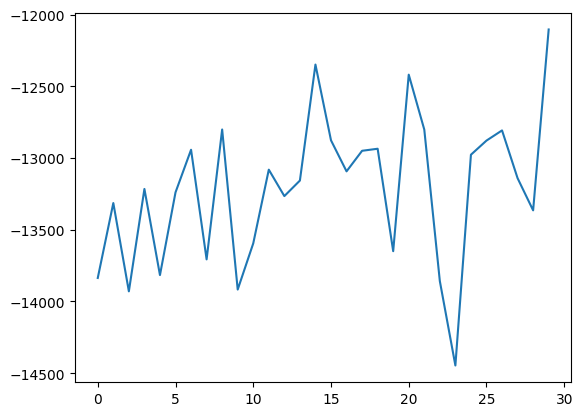

In [10]:
plt.plot(total_loss)

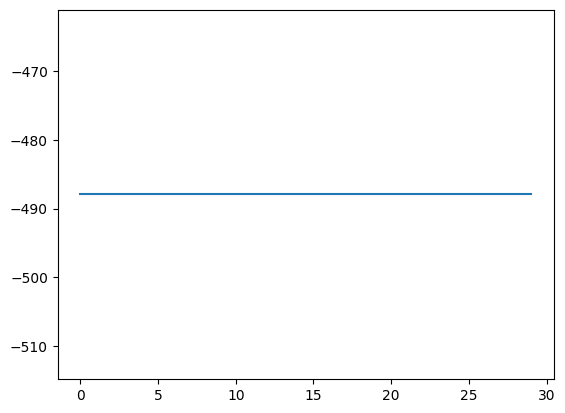

In [11]:
plt.plot(rewards_ma)

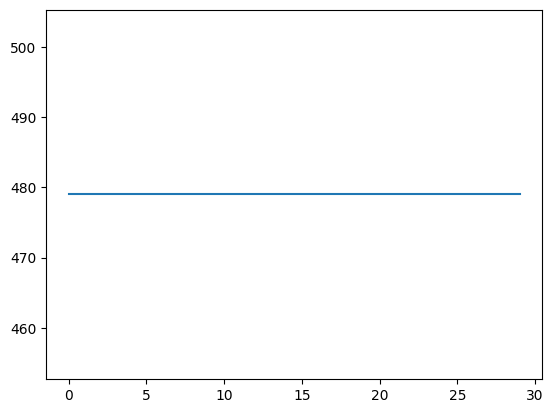

In [12]:
plt.plot(run_duration)

In [6]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from simglucose.simulation.rendering import Viewer
from collections import namedtuple
from datetime import timedelta
from datetime import datetime


now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

In [7]:
from DAAN572_Project.policies import ContinuousPolicy
pi = ContinuousPolicy(63) 

In [91]:
pi.rewards = list()
pi.log_probabilities = list()

In [92]:
max_episodes = 100
max_trajectory_length = 480
discount_factor = 0.95
epsilon = 0.95
running_bg = []
carbs = 110
scen = [(1,carbs), (5, carbs), (9, 300), (13, carbs), (17,carbs), (21,carbs)]
optimizer = optim.Adam(pi.parameters(), lr = 0.0001)

In [93]:
patient = T1DPatient.withName('adolescent#002')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
env.reset()

scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)
env.patient.observation


observation(Gsub=152.41)

In [94]:
for epi in tqdm(range(max_episodes)):


    patient = T1DPatient.withName('adolescent#002')
    sensor = CGMSensor.withName('Dexcom', seed=1)
    pump = InsulinPump.withName('Insulet')
    env.reset()
    
    scenario = CustomScenario(start_time=start_time, scenario=scen)
    env = T1DSimEnv(patient, sensor, pump, scenario)
    env.patient.observation

    ####################################
    ### INSTANTIATE OBSERVATION VARS ###
    ####################################

    observation = env.patient.observation[0]
    observation = ((env.patient.observation[0]-39))/400
    observation_lag = observation
    observation_change = observation - observation_lag        
    observation_hist = np.zeros(state_lookback)
    for i in range(state_lookback):
        observation_hist[i] = observation_change
    observation_hist_norm = observation_hist


    #######################################
    ### INSTANTIATE ACTION HISTORY VARS ###
    #######################################
    insulin = 0.025
    insulin_norm = insulin / 30
    insulin_lag = insulin_norm
    insulin_hist = np.zeros(state_lookback)
    for i in range(state_lookback):
        insulin_hist[i] = insulin_norm
    insulin_hist_norm = insulin_hist


    ##############################################
    ### INSTANTIATE PLANNED MEAL HISTORY ARRAY ###
    ##############################################
    planned_meal = env.patient.planned_meal
    planned_meal_hist = np.zeros(state_lookback)
    planned_meal_hist_norm = planned_meal_hist
    planned_meal = 0
    planned_meal_lag = 0


    ################################################
    ### INSTANTIATE CUSTOM REWARD FUNCTION ARRAY ###
    ################################################
    CVGA_scores = []
    unobserved_CVGA_scores = np.zeros(8)    
    for i in range(8):
        unobserved_CVGA_scores[i] = -65    

    #################################
    ### INSTANTIATE CUR STATE VAR ###
    #################################

    state = np.concatenate((observation, observation_hist_norm, insulin_norm, insulin_hist_norm, planned_meal, planned_meal_hist_norm), axis=None).squeeze()
    
    ###############################
    ### LOOP THROUGH TRAJECTORY ###
    ###############################
    
    for t in range(max_trajectory_length):


        ########################
        ### DETERMINE ACTION ###
        ########################

    #     if random.uniform(0, 1) < epsilon:
        insulin = pi.act(torch.from_numpy(state.astype(np.float32)))
#         print(insulin)


        ######################
        ### PERFORM ACTION ###
        ######################
        observation, reward, done, _ = env.step(insulin)  
    #     observation, reward, done, _ = env.step(0)  


        ##########################################
        ### POPULATE OBSERVATION HISTORY ARRAY ###
        ##########################################
        observation = (observation[0]-39)/400           # normalize glucose level to a value between 0 and 1
        observation_chg = observation - observation_lag   # create change value since previous time period
        observation_hist = np.roll(observation_hist,1)    # cycle the array by 1 position and move the oldest value from the rightmost position to first position
        observation_hist[0] = observation_chg             # replace first value in array (aka - the oldest value) with the most recent glucose change value

        # normalize the observation history into a new array for NN processing
        # the values are already normalized into the observable range of the CGM device of 39 to 600
        # so it is not required to use np.linalg function - just copy the array into new array for 
        # consistent naming convention

        observation_hist_norm = observation_hist     

        # if np.max(observation_hist) == 0:
        #     observation_hist_norm = np.zeros(20)
        # else:
        #     observation_hist_norm = observation_hist / np.linalg.norm(observation_hist)   


        #####################################
        ### POPULATE ACTION HISTORY ARRAY ###
        #####################################
        insulin_norm = insulin / 30                       # normalize insulin val to restrict it to between 0 and 1
        insulin_chg = insulin_norm - insulin_lag               # create action change value since prev time period
        insulin_hist = np.roll(insulin_hist,1)            # cycle action array by 1 position move the oldest value from the rightmost position to the first position
        insulin_hist[0] = insulin_chg                     # replace first value in array (aka - the oldest value) with the most recent action change value

        # normalize the action history array into a new array for NN processing
        insulin_hist_norm = insulin_hist


        ###########################################
        ### POPULATE PLANNED MEAL HISTORY ARRAY ###
        ###########################################
        planned_meal = env.patient.planned_meal        # extract planned meal value of current state
        planned_meal_chg = planned_meal - planned_meal_lag # create change value of planned meal since previous state
        planned_meal_hist = np.roll(planned_meal_hist,1)   # cycle planed meal array by 1 position move the oldest value from the rightmost position to the first position
        planned_meal_hist[0] = planned_meal_chg            # replace first value in array (aka - the oldest value) with the most recent action change value

        # normalize the planned meal history into a new array for NN processing
        if np.max(planned_meal_hist) == 0:
            planned_meal_hist_norm = np.zeros(state_lookback)
        else:
            planned_meal_hist_norm = planned_meal_hist / np.linalg.norm(planned_meal_hist)     


        ####################################
        ### POPULATE CURRENT STATE ARRAY ###
        ####################################

        state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()
    #     state = state.reshape((63, 1))

        #####################################################
        ### MANIPULATE REWARDS VALUE WITH CUSTOM FUNCTION ###
        #####################################################
        running_bg.append(observation)          
        variability_score = 0
        if t > 1 and t % 60 == 0:
            min_bg = np.percentile(running_bg, 2.5) 
            max_bg = np.percentile(running_bg, 97.5) 
            bg_range = (min_bg,max_bg)
            variability_score = -CVGA_score(bg_range)
            period_idx = int(t/60) - 1
            unobserved_CVGA_scores[period_idx] = 0
            running_bg = []        
    #         if done:
        if t == 480:
            done = TRUE            
            reward = reward + sum(unobserved_CVGA_scores)  

        reward = reward + variability_score              


        #######################################
        ### APPEND REWARDS TO REWARDS ARRAY ###
        #######################################
        pi.rewards.append(reward)

#         print("Time: ",t,((state[0]*400)+39))

        ######################################################################
        ### REPOPULATE LAG VARS WITH CUR STATE VALS IN PREP OF NEXT ACTION ###
        ######################################################################
        observation_lag = observation
        planned_meal_lag = planned_meal
        insulin_lag = insulin_norm

    #     if done: 
    #         break    

            
    ###################################
    ### COMPUTE LOSS AND SUM REWARD ###
    ###################################
    loss = compute_loss(pi, optimizer, discount_factor)
    total_loss.append(loss.item())
    total_reward = sum(pi.rewards)
    run_duration.append(t)
    
    
    ########################################
    ### RESET POLICY FOR NEXT TRAJECTORY ###
    ########################################
    pi.reset()
    
    
    #######################################
    ### CALCULATE MOVING AVERAGE REWARD ###
    #######################################
#     if len(rewards_queue) > state_lookback:
    if epi > 1:
        rewards_queue.popleft()
    rewards_queue.append(total_reward)
    mean_reward = np.mean(rewards_queue)
    rewards_ma.append(mean_reward)

    # Save the policy net
    if epi % 10 == 0:
        torch.save(pi.state_dict(), 'cont_policy_net3')
   
        
torch.save(pi.state_dict(), 'cont_policy_net3')

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:14<00:00,  3.74s/it]


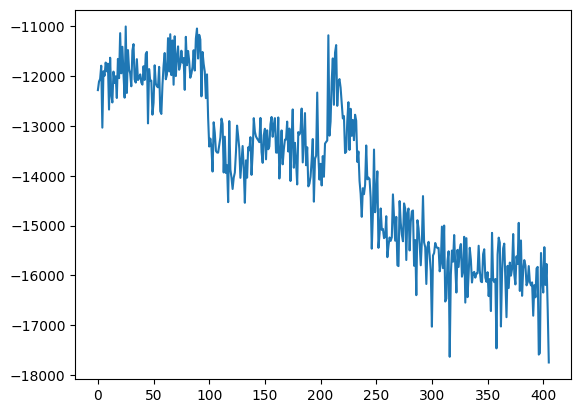

In [95]:
plt.plot(total_loss)

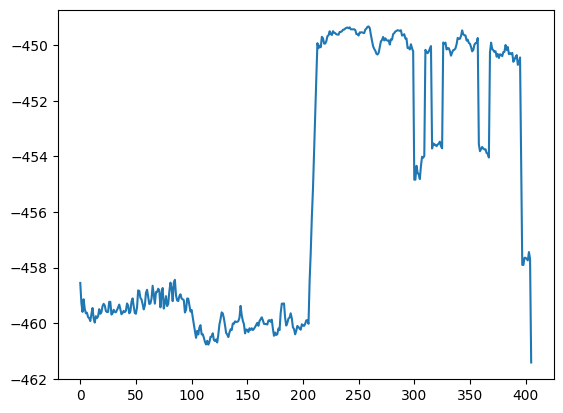

In [96]:
plt.plot(rewards_ma)

In [97]:
max_episodes = 20
max_trajectory_length = 480
discount_factor = 0.95
epsilon = 0.95
running_bg = []
carbs = 180
scen = [(1,carbs), (5, carbs), (9, 300), (13, carbs), (17,carbs), (21,carbs)]
optimizer = optim.Adam(pi.parameters(), lr = 0.0001)

In [98]:

patient = T1DPatient.withName('adolescent#002')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
env.reset()

scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)
env.patient.observation

####################################
### INSTANTIATE OBSERVATION VARS ###
####################################

observation = env.patient.observation[0]
observation = ((env.patient.observation[0]-39))/400
observation_lag = observation
observation_change = observation - observation_lag        
observation_hist = np.zeros(state_lookback)
for i in range(state_lookback):
    observation_hist[i] = observation_change
observation_hist_norm = observation_hist


#######################################
### INSTANTIATE ACTION HISTORY VARS ###
#######################################
insulin = 0.025
insulin_norm = insulin / 30
insulin_lag = insulin_norm
insulin_hist = np.zeros(state_lookback)
for i in range(state_lookback):
    insulin_hist[i] = insulin_norm
insulin_hist_norm = insulin_hist


##############################################
### INSTANTIATE PLANNED MEAL HISTORY ARRAY ###
##############################################
planned_meal = env.patient.planned_meal
planned_meal_hist = np.zeros(state_lookback)
planned_meal_hist_norm = planned_meal_hist
planned_meal = 0
planned_meal_lag = 0


################################################
### INSTANTIATE CUSTOM REWARD FUNCTION ARRAY ###
################################################
CVGA_scores = []
unobserved_CVGA_scores = np.zeros(8)    
for i in range(8):
    unobserved_CVGA_scores[i] = -65    

#################################
### INSTANTIATE CUR STATE VAR ###
#################################

state = np.concatenate((observation, observation_hist_norm, insulin_norm, insulin_hist_norm, planned_meal, planned_meal_hist_norm), axis=None).squeeze()
# state = state.reshape((1, 63))
print(state)

for t in range(480):
#     env.render(mode='human')
#     print(state)


    ########################
    ### DETERMINE ACTION ###
    ########################

#     if random.uniform(0, 1) < epsilon:
    insulin = pi.act(torch.from_numpy(state.astype(np.float32)))
    print(insulin)


    ######################
    ### PERFORM ACTION ###
    ######################
    observation, reward, done, _ = env.step(insulin)  
#     observation, reward, done, _ = env.step(0)  


    ##########################################
    ### POPULATE OBSERVATION HISTORY ARRAY ###
    ##########################################
    observation = (observation[0]-39)/400           # normalize glucose level to a value between 0 and 1
    observation_chg = observation - observation_lag   # create change value since previous time period
    observation_hist = np.roll(observation_hist,1)    # cycle the array by 1 position and move the oldest value from the rightmost position to first position
    observation_hist[0] = observation_chg             # replace first value in array (aka - the oldest value) with the most recent glucose change value

    # normalize the observation history into a new array for NN processing
    # the values are already normalized into the observable range of the CGM device of 39 to 600
    # so it is not required to use np.linalg function - just copy the array into new array for 
    # consistent naming convention

    observation_hist_norm = observation_hist     

    # if np.max(observation_hist) == 0:
    #     observation_hist_norm = np.zeros(20)
    # else:
    #     observation_hist_norm = observation_hist / np.linalg.norm(observation_hist)   


    #####################################
    ### POPULATE ACTION HISTORY ARRAY ###
    #####################################
    insulin_norm = insulin / 30                       # normalize insulin val to restrict it to between 0 and 1
    insulin_chg = insulin_norm - insulin_lag               # create action change value since prev time period
    insulin_hist = np.roll(insulin_hist,1)            # cycle action array by 1 position move the oldest value from the rightmost position to the first position
    insulin_hist[0] = insulin_chg                     # replace first value in array (aka - the oldest value) with the most recent action change value

    # normalize the action history array into a new array for NN processing
    insulin_hist_norm = insulin_hist

    
    ###########################################
    ### POPULATE PLANNED MEAL HISTORY ARRAY ###
    ###########################################
    planned_meal = env.patient.planned_meal        # extract planned meal value of current state
    print("PLANNED MEAL: ",planned_meal)
    planned_meal_chg = planned_meal - planned_meal_lag # create change value of planned meal since previous state
    planned_meal_hist = np.roll(planned_meal_hist,1)   # cycle planed meal array by 1 position move the oldest value from the rightmost position to the first position
    planned_meal_hist[0] = planned_meal_chg            # replace first value in array (aka - the oldest value) with the most recent action change value

    # normalize the planned meal history into a new array for NN processing
    if np.max(planned_meal_hist) == 0:
        planned_meal_hist_norm = np.zeros(state_lookback)
    else:
        planned_meal_hist_norm = planned_meal_hist / np.linalg.norm(planned_meal_hist)     


    ####################################
    ### POPULATE CURRENT STATE ARRAY ###
    ####################################
    
    state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()
#     state = state.reshape((63, 1))

    #####################################################
    ### MANIPULATE REWARDS VALUE WITH CUSTOM FUNCTION ###
    #####################################################
    running_bg.append(observation)          
    variability_score = 0
    if t > 1 and t % 60 == 0:
        min_bg = np.percentile(running_bg, 2.5) 
        max_bg = np.percentile(running_bg, 97.5) 
        bg_range = (min_bg,max_bg)
        variability_score = -CVGA_score(bg_range)
        period_idx = int(t/60) - 1
        unobserved_CVGA_scores[period_idx] = 0
        running_bg = []        
#         if done:
    if t == 480:
        done = TRUE            
        reward = reward + sum(unobserved_CVGA_scores)  

    reward = reward + variability_score              


    #######################################
    ### APPEND REWARDS TO REWARDS ARRAY ###
    #######################################
#     pi.rewards.append(reward)

    print("Time: ",t,((state[0]*400)+39))

    ######################################################################
    ### REPOPULATE LAG VARS WITH CUR STATE VALS IN PREP OF NEXT ACTION ###
    ######################################################################
    observation_lag = observation
    planned_meal_lag = planned_meal
    insulin_lag = insulin_norm

#     if done: 
#         break    

            
print('Complete')



[0.2835 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008
 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008
 0.0008 0.0008 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
1.0171119
PLANNED MEAL:  0
Time:  0 168.0637310506602
0.0
PLANNED MEAL:  0
Time:  1 164.97171088436903
1.3007625
PLANNED MEAL:  0
Time:  2 162.6264812274855
0.7985132
PLANNED MEAL:  0
Time:  3 160.84918919484772
0.0
PLANNED MEAL:  0
Time:  4 159.45592729699456
0.16556372
PLANNED MEAL:  0
Time:  5 158.25659287096155
0.41408792
PLANNED MEAL:  0
Time:  6 157.05596243859944
0.0
PLANNED MEAL:  0
Time:  7 155.65750053544673
0.80573857
PLANNED MEAL:  0
Time:  8 153.86636781034684
0.009979168
PLANNED MEAL:  0
Time:  9 151.52598009824916
0.26127237
PLANNED MEAL:  0
Time

Time:  153 251.68147655572466
2.0135813
PLANNED MEAL:  0
Time:  154 238.34017059633317
0.23122896
PLANNED MEAL:  0
Time:  155 225.29159180229283
0.0
PLANNED MEAL:  0
Time:  156 212.56800514543858
1.0622803
PLANNED MEAL:  0
Time:  157 200.1957068522219
0.0
PLANNED MEAL:  0
Time:  158 188.19499139227946
0.0
PLANNED MEAL:  0
Time:  159 176.58107014125287
0.0
PLANNED MEAL:  0
Time:  160 165.36384123135767
0.48033595
PLANNED MEAL:  0
Time:  161 154.54634646764288
0.05144722
PLANNED MEAL:  0
Time:  162 144.1290750820329
0.0
PLANNED MEAL:  0
Time:  163 134.1110347377624
1.2700905
PLANNED MEAL:  0
Time:  164 124.49532736648857
0.0
PLANNED MEAL:  0
Time:  165 115.31762335160269
0.66746485
PLANNED MEAL:  0
Time:  166 106.6632007931288
1.794722
PLANNED MEAL:  0
Time:  167 98.62719706357922
0.0
PLANNED MEAL:  0
Time:  168 91.30349059145323
0.0
PLANNED MEAL:  0
Time:  169 84.76380110330147
0.0
PLANNED MEAL:  0
Time:  170 78.95287249728403
0.0
PLANNED MEAL:  0
Time:  171 73.62597433559199
0.0
PLANNE

0.70444477
PLANNED MEAL:  0
Time:  327 115.48171721713592
0.0
PLANNED MEAL:  0
Time:  328 110.46546970566776
1.0404422
PLANNED MEAL:  0
Time:  329 105.49100859480754
1.0944471
PLANNED MEAL:  0
Time:  330 100.5657466030357
0.0
PLANNED MEAL:  0
Time:  331 96.12133491028872
0.0
PLANNED MEAL:  0
Time:  332 92.67524138976329
0.6414097
PLANNED MEAL:  0
Time:  333 90.74168827036138
0.11636929
PLANNED MEAL:  0
Time:  334 90.73558225377518
0.0
PLANNED MEAL:  0
Time:  335 92.43400861090606
1.8090162
PLANNED MEAL:  0
Time:  336 94.6468915313803
2.6083405
PLANNED MEAL:  0
Time:  337 95.97263705344065
0.0
PLANNED MEAL:  0
Time:  338 95.01092084795611
0.5330511
PLANNED MEAL:  0
Time:  339 90.50363184467568
0.18286885
PLANNED MEAL:  165
Time:  340 82.06016998571721
0.0
PLANNED MEAL:  150
Time:  341 70.62208025644024
0.0
PLANNED MEAL:  135
Time:  342 57.49154882544562
7.088362
PLANNED MEAL:  120
Time:  343 45.25651715704293
0.0
PLANNED MEAL:  105
Time:  344 39.0
6.486235
PLANNED MEAL:  90
Time:  345 3

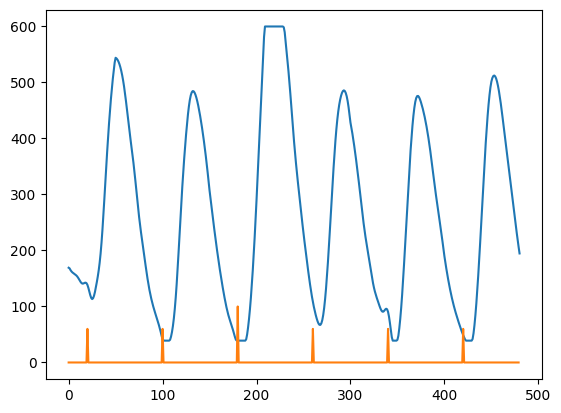

In [99]:
plt.plot(env.CGM_hist)
plt.plot(env.CHO_hist)


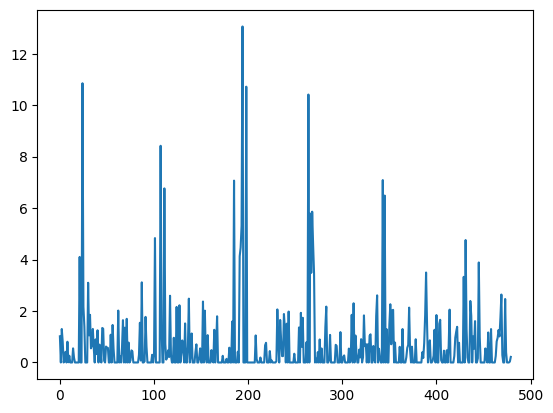

In [100]:
plt.plot(env.insulin_hist)